In [24]:
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.pbh import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.integrate
import numba
import pickle
import tqdm
from bisect import bisect_left

In [2]:
import emcee
import corner

In [3]:
%matplotlib inline
%config InlineBackend.figure_format=''
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 150

In [4]:
ds=8

In [5]:
l=0
b=0
m_lens = 1
pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds)
ts = np.logspace(1,4,50)

In [6]:
pbh.l=00
pbh.b=00

In [26]:
def sample_density(params, # galactic longitude (degrees)
                 # b, # galactic latitide (degrees)
                 # dl,  # lens distance from Earth (kpc)
                 # ds,  # source distance from Earth (kpc)
                 this_pbh, # LensCalcPy.pbh object
                 lbounds=(-10,10),
                 bbounds=(-10,10),
                 #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    this_pbh.l, this_pbh.b, dl, this_pbh.ds, umin, crossing_time = params
    if this_pbh.l < lbounds[0] \
    or this_pbh.l > lbounds[1] \
    or this_pbh.b > bbounds[1] \
    or this_pbh.b < bbounds[0] \
    or dl < 0 or dl > this_pbh.ds \
    or umin <= 0 \
    or crossing_time <= 0:
        return 0
    prob = this_pbh.differential_rate_integrand(umin ,dl, crossing_time, this_pbh.mw_model)
    # multiply by expected number of stars in volume element 
    expected_stars = (np.pi/180)**2 * this_pbh.ds**2 * np.cos(this_pbh.b*np.pi/180) * \
            this_pbh.mw_model.density_stars(this_pbh.ds, \
                                            this_pbh.l,  \
                                            this_pbh.b) 
    prob*=expected_stars   
    if prob < 0 or np.isnan(prob):
        print(f"error: expected stars = {expected_stars}")
        print(f"density: {this_pbh.mw_model.density_stars(this_pbh.ds, this_pbh.l, this_pbh.b) }")
        print(f"cos(b): {np.cos(this_pbh.b)}")
        return 0
    return prob

def sample_density_log(params, # galactic longitude (degrees)
                     # b, # galactic latitide (degrees)
                     # dl,  # lens distance from Earth (kpc)
                     # ds,  # source distance from Earth (kpc)
                     this_pbh, # LensCalcPy.pbh object
                     lbounds=(-10,10),
                     bbounds=(-10,10),
                     #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    return np.log(sample_density(params, this_pbh, lbounds, bbounds))

Units for the above:
'differential_rate_integrand' is in $(\text{h})^{-2} (\text{kpc})^{-1}$.
'density_stars' is in $(\text{kpc})^{-3} M_\odot$

So, integrate over observing time, event time, observing volume and line of sight to get expected number of events?

Idea: take average of $\text{rate}(\text{events})/\text{kde}(\text{events})$ to get integrated event rate


In [10]:
with open('eventsamples.pkl', 'rb') as eventsamples:
    exsamples = pickle.load(eventsamples)

In [27]:
ndims = 6
nwalkers = 12

sampler = emcee.EnsembleSampler(nwalkers,ndims,sample_density_log, args=[pbh, (-90,90),(-45,45)])

In [12]:
p0 = exsamples[np.random.choice(exsamples.shape[0], size=nwalkers, replace=False)]


In [16]:
for i,p in enumerate(p0):
    this_prob = sample_density_log(p, pbh)
    while np.isinf(this_prob):
        p0[i] = exsamples[np.random.choice(exsamples.shape[0], size=1)]
        this_prob = sample_density_log(p, pbh)
    print(f'{p0[i]}:{this_prob}')

[-9.57929285e-01 -1.17580896e+00  8.49022622e+00  9.59306937e+00
  7.21561582e-01  1.76377060e+03]:-11.823814727994446
[ 1.07108926e+00 -9.06304379e-01  8.48506782e+00  8.65673467e+00
  3.37250397e-01  1.46761331e+03]:-10.496344847290109
[  4.74196662  -4.96890411   1.37288839  10.28945083   0.8713746
 507.54374806]:-16.65748199817601
[5.96742157e+00 1.13986774e+00 9.28498821e+00 1.03701230e+01
 8.37132381e-02 1.56101532e+03]:-14.664531677483033
[-7.61821832e+00  6.38729094e-02  7.89890842e+00  1.03496036e+01
  7.54614536e-01  1.12046041e+03]:-14.360193371088423
[5.88424858e+00 6.10024551e-01 6.65602237e+00 7.94520531e+00
 4.43250720e-01 2.70766666e+03]:-15.551721990475142
[ 4.14514540e+00 -2.58503733e+00  8.81940502e+00  9.20752850e+00
  5.93627904e-01  1.96182387e+03]:-12.76659048625154
[-3.52167826e-01 -2.41610790e-01  5.55234785e+00  7.67097167e+00
  8.84315792e-01  1.10453523e+03]:-13.826635566866901
[-1.98604481e+00 -1.85377428e-03  6.93857486e+00  1.26642874e+01
  3.85906721e-02

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_35934/2742214609.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(sample_density(params, this_pbh))


In [28]:
nsteps=210000
state = sampler.run_mcmc(p0,nsteps)#, skip_initial_state_check=True)
samples = sampler.get_chain(flat=True, discard=10000)

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_35934/3477898468.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(sample_density(params, this_pbh, lbounds, bbounds))


In [97]:
with open(f"eventsamples_{len(samples)}.pkl", mode='wb') as samplefile:
    pickle.dump(samples, samplefile)

Text(0, 0.5, 'Galactic latitude b (degrees)')

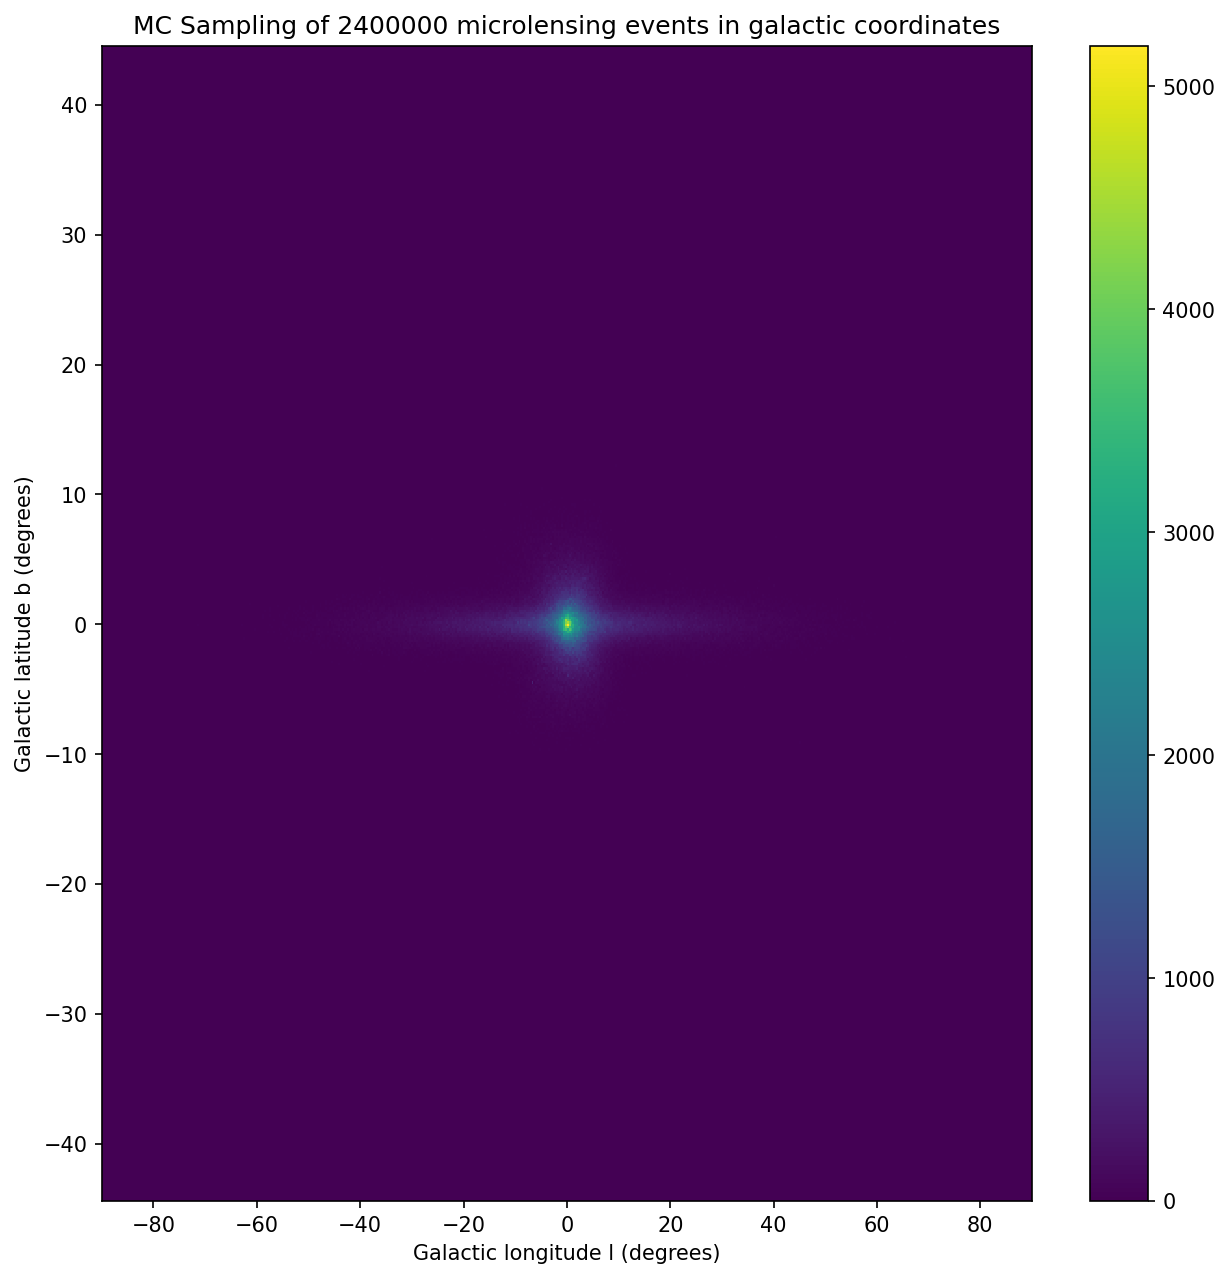

In [29]:
plt.subplots(figsize=(10,10))

hist, xedges, yedges, im = plt.hist2d(*samples[:,:2].T, bins=500);
plt.colorbar()
plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')


Text(0, 0.5, 'Galactic latitude b (degrees)')

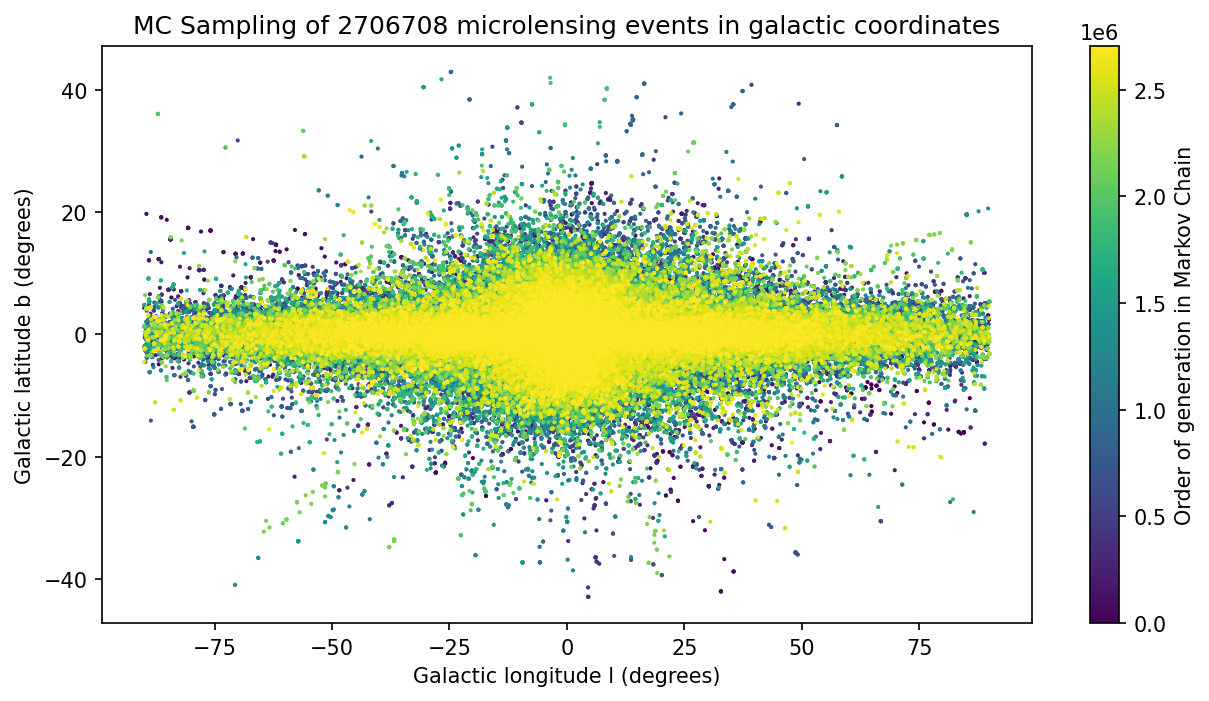

In [243]:

x,y = samples[:,:2].T
plt.scatter(x,y, c=np.arange(len(x)),s=1)
cbar = plt.colorbar()
cbar.set_label('Order of generation in Markov Chain')
plt.title(f'MC Sampling of {len(samples)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

Text(0, 0.5, 'Galactic latitude b (degrees)')

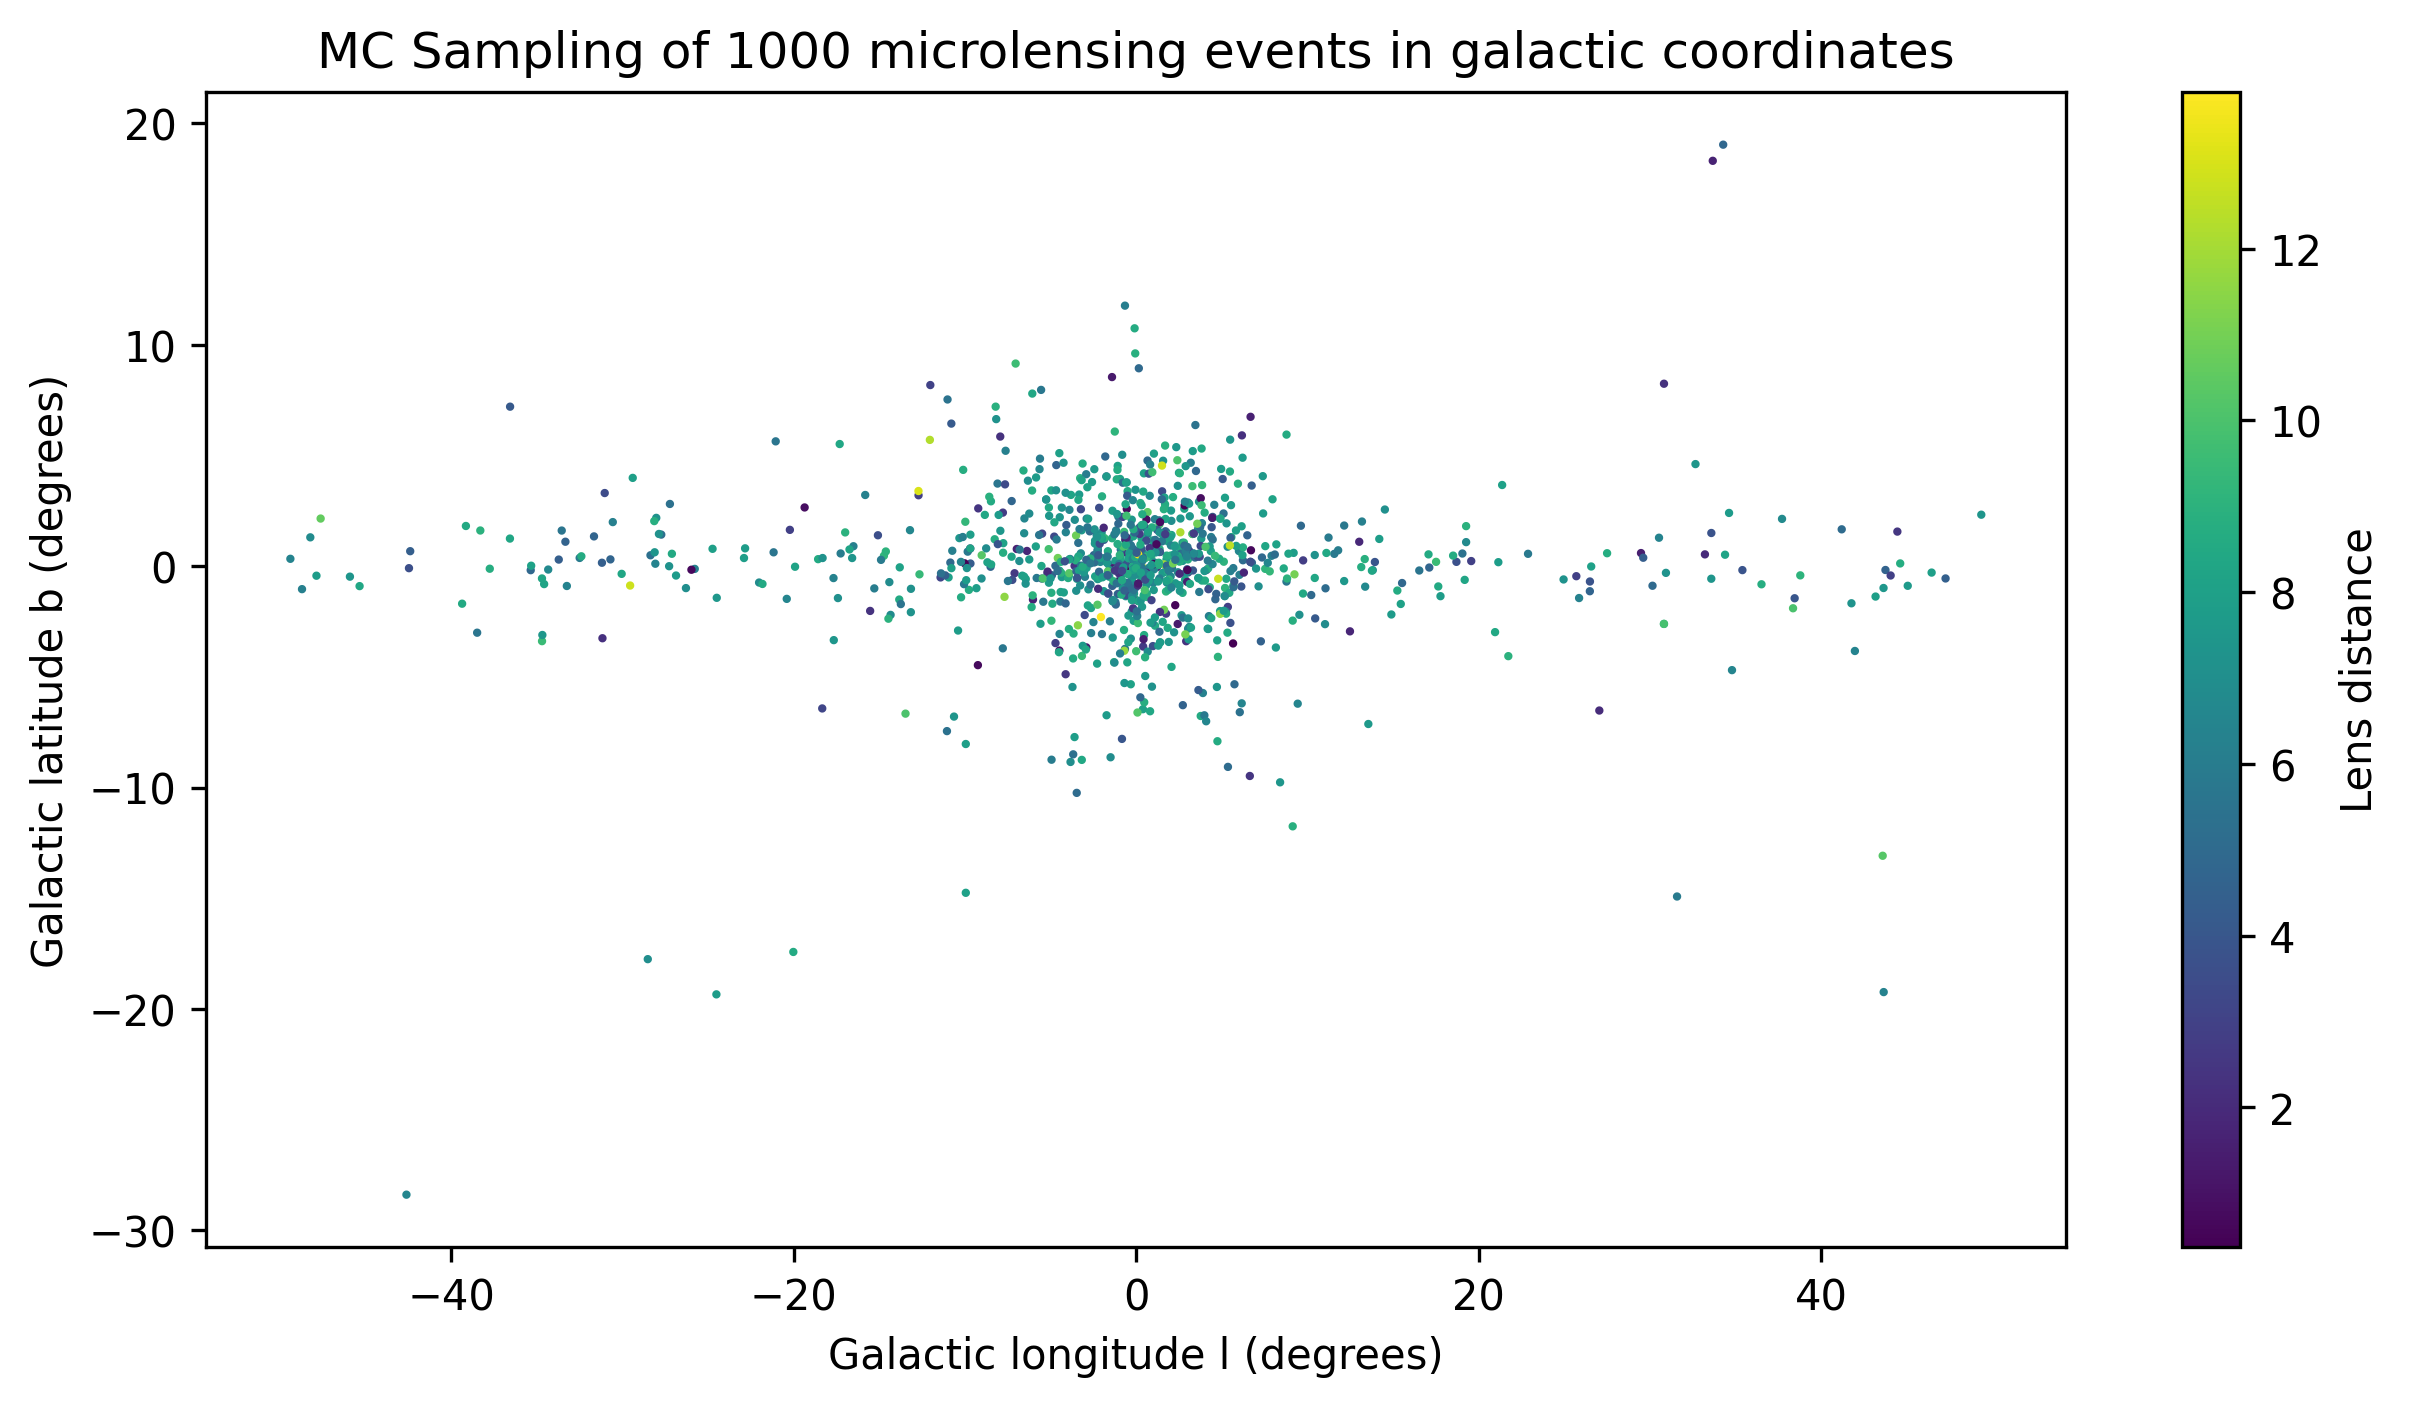

In [430]:

x,y,dists = samples[np.random.choice(np.arange(len(samples)), 1000)][:,:3].T
distsort = np.argsort(dists)
plt.scatter(x[distsort],y[distsort], c=dists,s=1)
cbar = plt.colorbar()
cbar.set_label('Lens distance')
plt.title(f'MC Sampling of {len(x)} microlensing events in galactic coordinates')
plt.xlabel('Galactic longitude l (degrees)')
plt.ylabel('Galactic latitude b (degrees)')

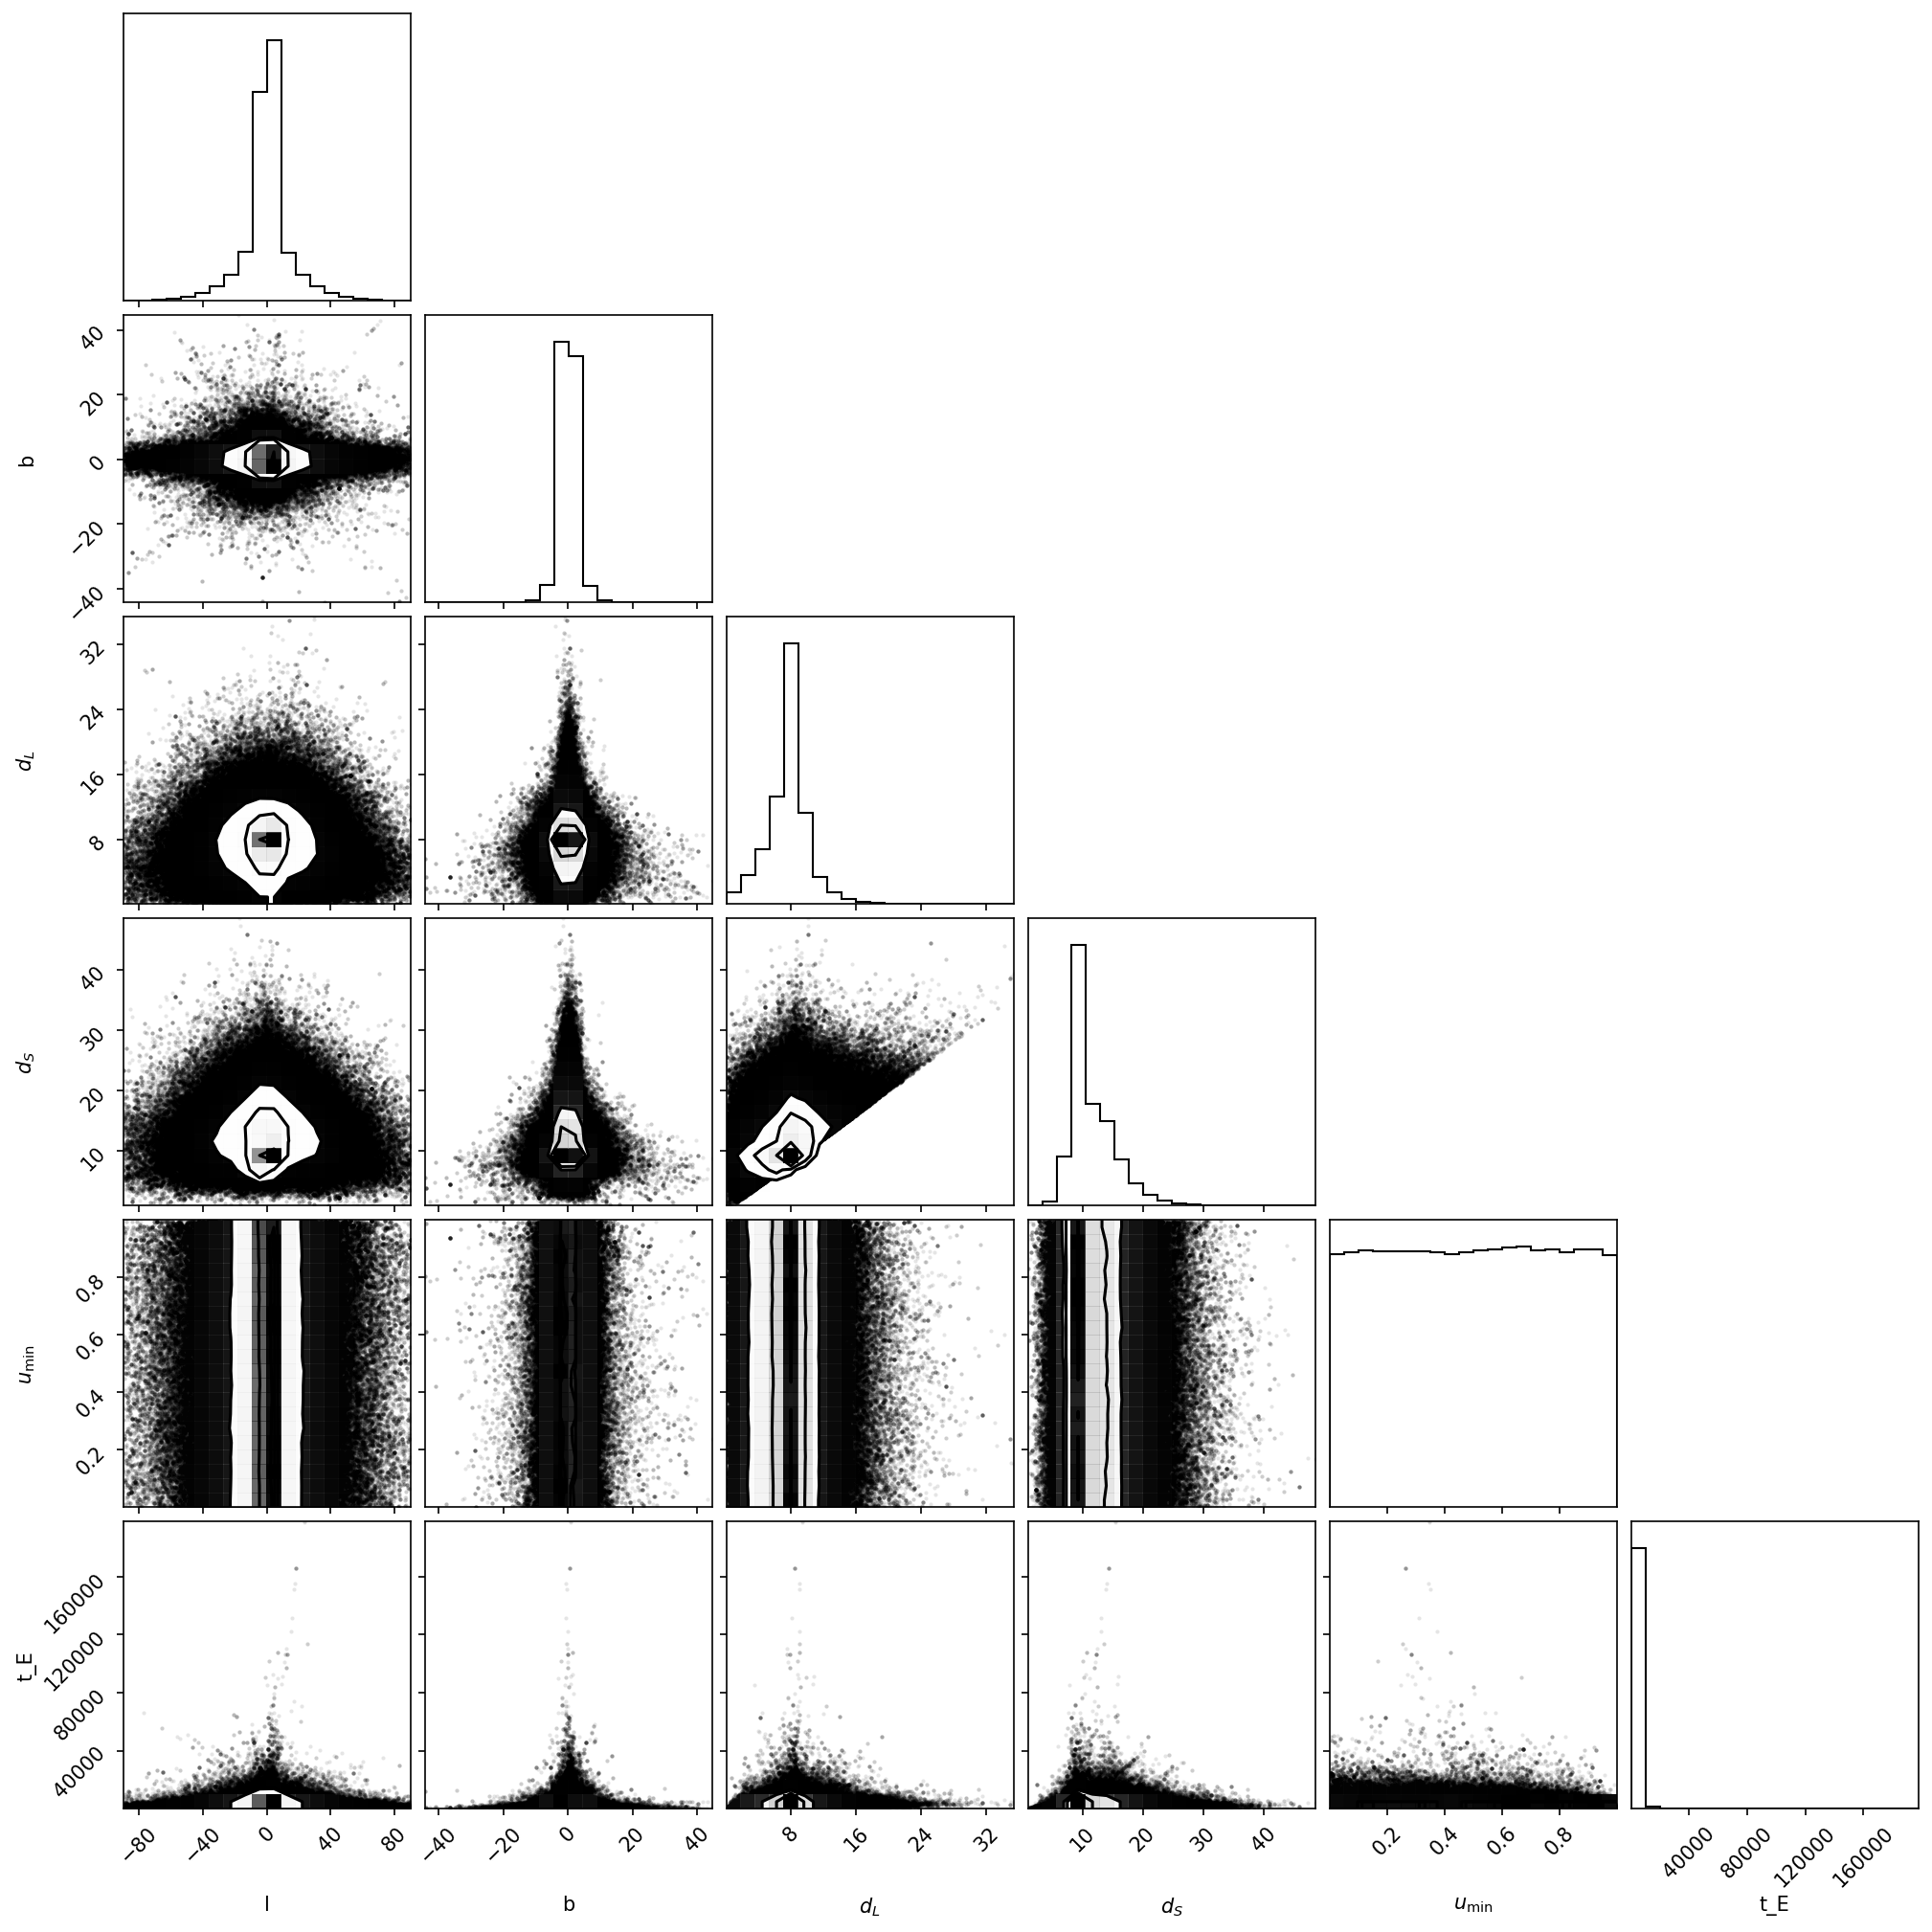

In [30]:
fig = corner.corner(
    samples, labels=['l','b',r'$d_L$',r'$d_S$',r'$u_\min$',r't_E'])

In [32]:
edges = np.linspace(np.min(samples, axis=0), np.max(samples, axis=0), 20)

In [33]:
binned_samples={} 
for nsample, sample in tqdm.tqdm(enumerate(samples)):
    indices = tuple(bisect_left(edges[:,icoord], sample[icoord]) for icoord in range(len(sample)))
    if indices in binned_samples:
        binned_samples[indices].append(sample)
    else:
        binned_samples[indices] = [sample]

2400000it [00:06, 368354.87it/s]


In [34]:
binned_counts_dict={}
for indices, sample_list in binned_samples.items():
    binned_counts_dict[indices] = len(sample_list)

In [39]:
def coord_to_bin_indices(edges, coords):
    return tuple(bisect_left(edges[:,icoord], coords[icoord]) for icoord in range(len(coords)))
def box_from_indices(edges, indices):
    return np.array([[edges[idx-1][i],edges[idx][i]] for i, idx in enumerate(indices)])

In [37]:
biggest_bin=max(binned_counts_dict, key=binned_counts_dict.get)

In [38]:
len(binned_samples[biggest_bin])

19812

In [41]:
box_from_indices(edges,biggest_bin)

array([[-4.73653283e+00,  4.73507023e+00],
       [-2.28503417e+00,  2.39541440e+00],
       [ 7.44256969e+00,  9.30156239e+00],
       [ 8.36434634e+00,  1.08782631e+01],
       [ 7.36828208e-01,  7.89458788e-01],
       [ 1.47679875e+01,  1.04177455e+04]])

In [ ]:
def region_volume(region):
    return np.product(region[:,1]-region[:,0])
def mc_integrate(f, region, nsamples=10000):
    sample_points = np.random.random(size=(nsamples, len(region)))
    sample_points = (region[:,1]-region[:,0])*sample_points+region[:,0]
    samples_values = [f(*_) for _ in sample_points]
    return np.mean(samples_values)*region_volume(region), np.std(samples_values)*region_volume(region)/np.sqrt(nsamples)


In [91]:
binned_rates_integral={} 
binned_rates_integral_stdev={}
for indices, these_samples in binned_samples.items():
    nsamples = max(300, len(these_samples))
    
    binned_rates_integral[indices], binned_rates_integral_stdev[indices] = \
            mc_integrate(lambda *params: sample_density(params, pbh), box_from_indices(edges,indices),nsamples=nsamples)


In [92]:
binned_rates_ratios = {ind:binned_rates_integral[ind]/binned_counts_dict[ind] for ind in binned_rates_integral}

In [93]:
ratio_array=np.array(list(binned_rates_ratios.values()))

In [95]:
integral_fractional_variances = np.array(list(binned_rates_integral_stdev[ind]/binned_rates_integral[ind] for ind in binned_rates_integral_stdev))

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_35934/1325571121.py:1: RuntimeWarning: invalid value encountered in scalar divide
  integral_fractional_variances = np.array(list(binned_rates_integral_stdev[ind]/binned_rates_integral[ind] for ind in binned_rates_integral_stdev))


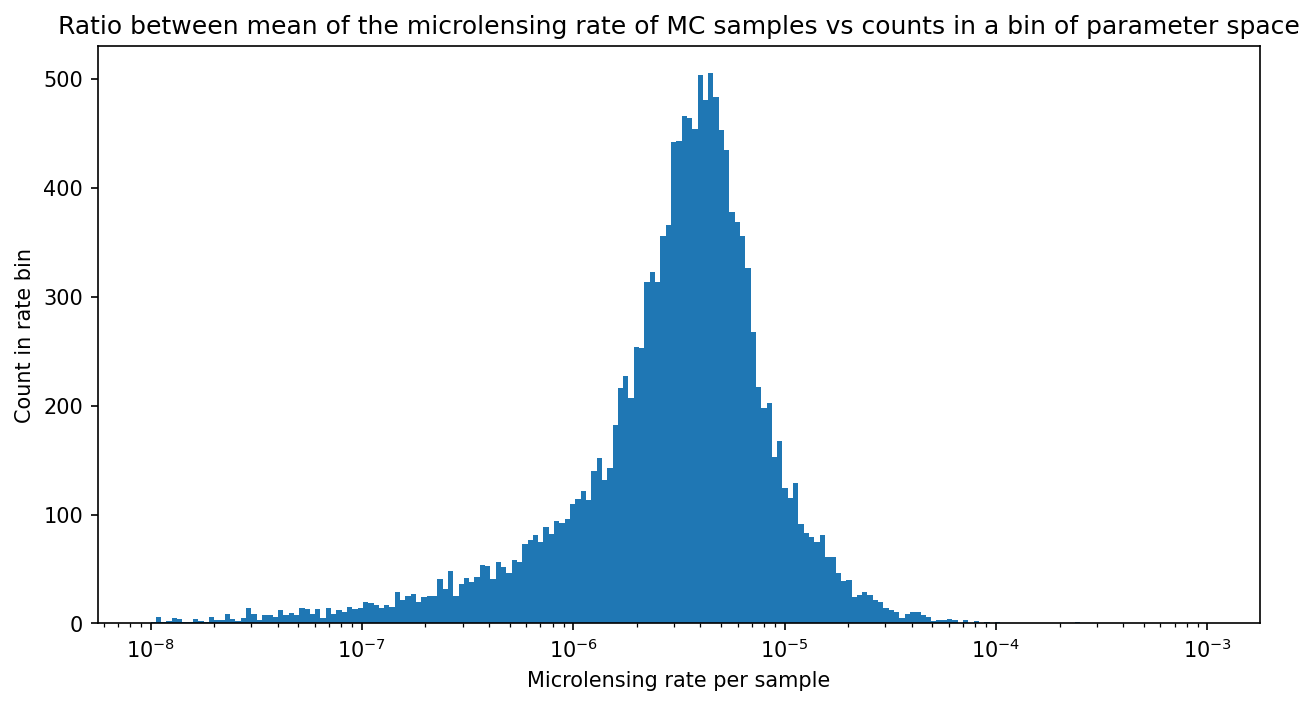

In [46]:
bins=np.logspace(-8,-3,200)
# bins = np.linspace(10**(-7), .1,200)
plt.hist(ratio_array,bins=bins)
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
plt.xscale('log')
#plt.yscale('log')

Text(0.5, 1.0, 'Fractional error on the mean in microlensing rate integral')

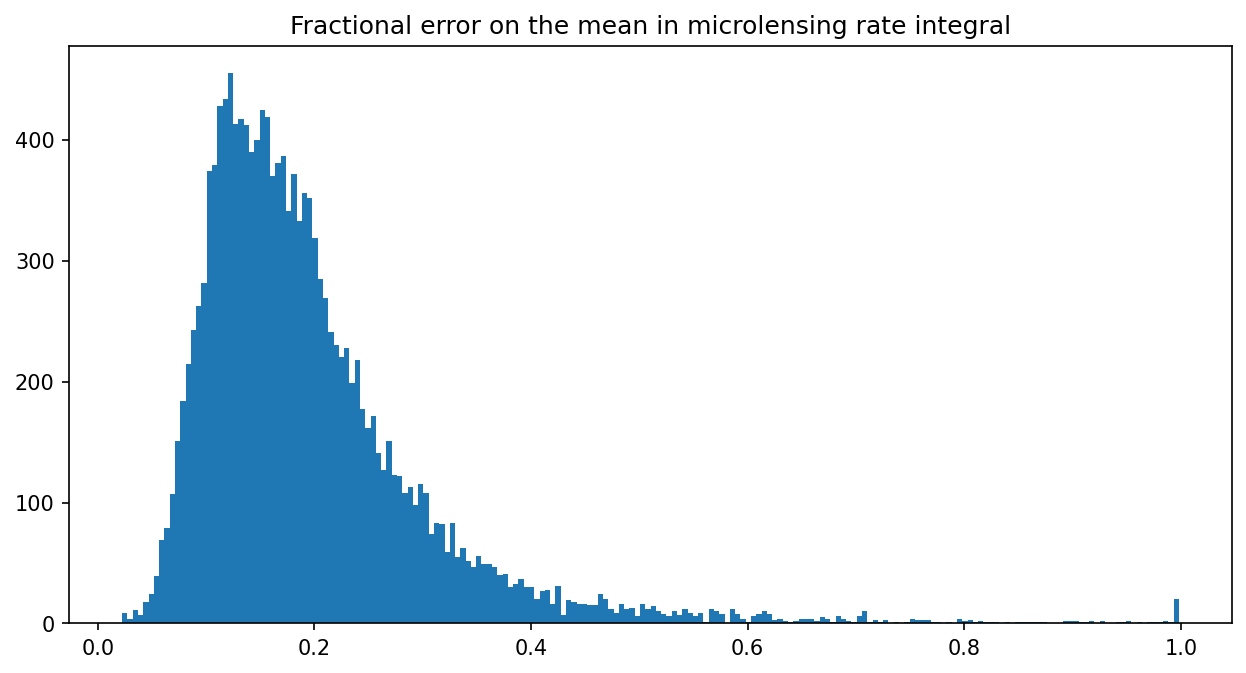

In [96]:
#bins=np.logspace(-8,-3,200)
# bins = np.linspace(10**(-7), .1,200)
plt.hist(integral_fractional_variances, bins=200)#,bins=bins)
plt.title('Fractional error on the mean in microlensing rate integral')
#plt.xscale('log')
#plt.yscale('log')

In [47]:
np.sum([ratio_array==0])/len(binned_rates_ratios)

0.6871349839598585

In [48]:
len(binned_rates_ratios)

48628

Text(0, 0.5, 'Count in rate bin')

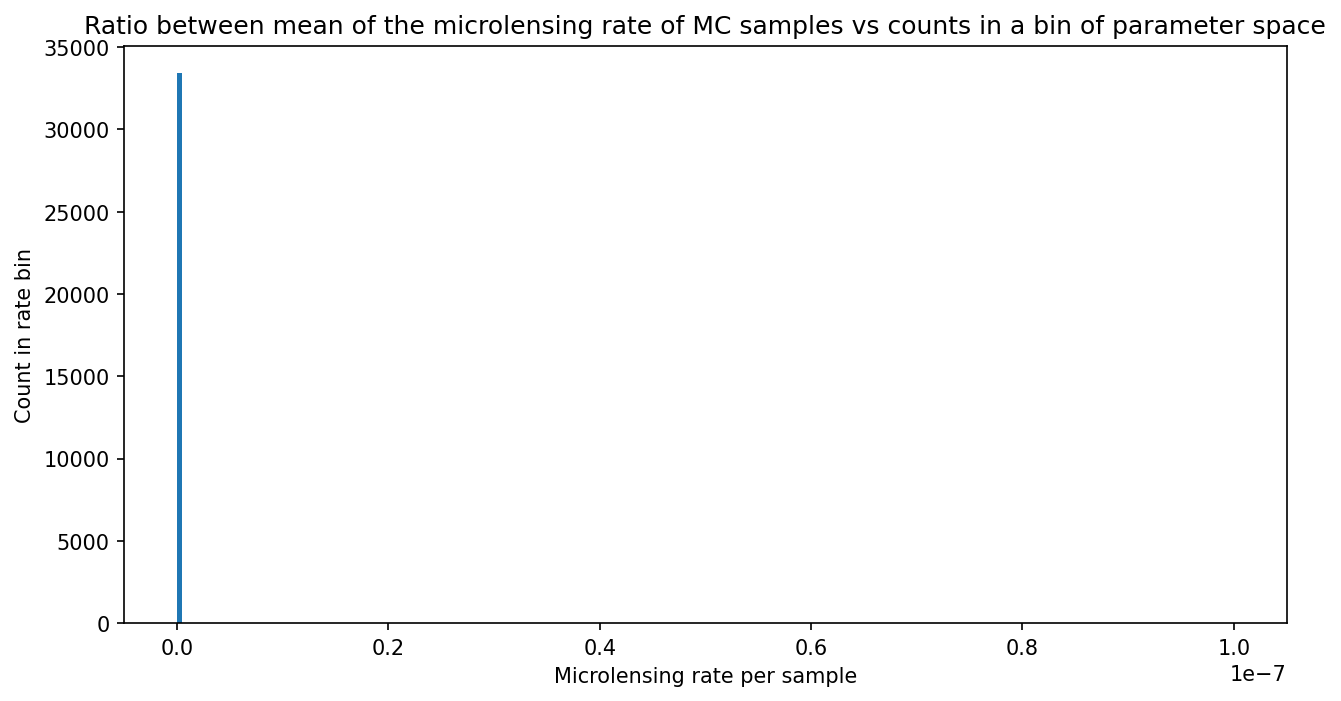

In [49]:
# bins=np.logspace(-8,-3,200)
bins = np.linspace(0, 10**(-7),200)
plt.hist(ratio_array,bins=bins)
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
plt.xlabel('Microlensing rate per sample')
plt.ylabel('Count in rate bin')
# plt.xscale('log')
#plt.yscale('log')

In [50]:
ratio_array

array([0.00000000e+00, 5.13397388e-06, 5.67326730e-06, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

# who's in the tails?

In [54]:
binned_rates_ratios_low_tail={}
bulge_bins = coord_to_bin_indices(edges[:,:2], [0,0])
for idx, ratio in binned_rates_ratios.items():
    if ratio/4<10**-7 and ratio :
        binned_rates_ratios_low_tail[idx] = ratio

In [55]:
low_tail_bins = np.array(list(binned_rates_ratios_low_tail.keys()))

In [56]:
print(low_tail_bins.mean(axis=0))
print(low_tail_bins.std(axis=0))


[ 9.97323136 10.00478011  6.06596558  7.92734226  9.61281071  1.87284895]
[0.92203246 1.12463128 3.53058859 3.7628655  5.21068438 1.42568923]


In [57]:
binned_rates_ratios_high_tail={}
for idx, ratio in binned_rates_ratios.items():
    if ratio/4>10**-5  :
        binned_rates_ratios_high_tail[idx] = ratio
high_tail_bins = np.array(list(binned_rates_ratios_high_tail.keys()))

# where are the sparse bins?

In [58]:
binned_rates_ratios_sparse={}
nsparse=500
bulge_bins = coord_to_bin_indices(edges[:,:2], [0,0])
for idx, ratio in binned_rates_ratios.items():
    if binned_counts_dict[idx] < nsparse:
        binned_rates_ratios_sparse[idx] = ratio

In [64]:
ratio_array_sparse=np.array(list(binned_rates_ratios_sparse.values()))


In [60]:
binned_rates_ratios_not_sparse = {idx: val for idx,val in binned_rates_ratios.items() if (idx not in binned_rates_ratios_sparse) }
ratio_array_not_sparse=np.array(list(binned_rates_ratios_not_sparse.values()))

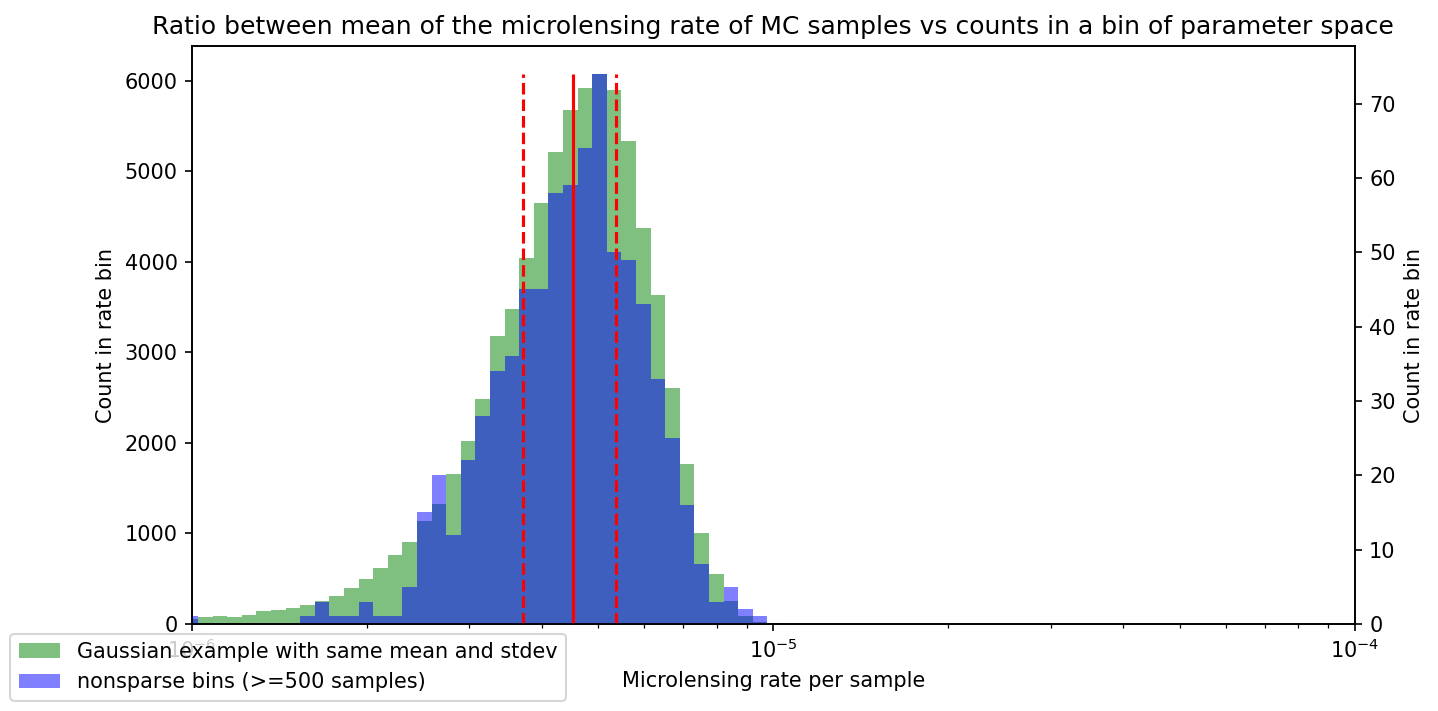

In [65]:
gauss_sample = np.random.normal(np.mean(ratio_array_not_sparse), np.std(ratio_array_not_sparse), size=100*len(ratio_array_not_sparse))
fig, ax1 = plt.subplots()
ax1.hist(gauss_sample,bins=np.logspace(-8,-3,200),label=fr'Gaussian example with same mean and stdev', alpha=.5,color='green')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
ax1.set_xlabel('Microlensing rate per sample')
ax1.set_ylabel('Count in rate bin')
ax1.set_xscale('log')
#ax1.set_ylim(0,7200)

ax2 = ax1.twinx()
vals, bins, hist = ax2.hist(ratio_array_not_sparse,bins=np.logspace(-8,-3,200),label=fr'nonsparse bins (>={nsparse} samples)',alpha=.5, color='blue')

ax2.set_xlabel('Microlensing rate per sample')
ax2.set_ylabel('Count in rate bin')
ax2.set_xscale('log')
ax2.set_xlim(10**-6, 10**-4)

mean_ratio = np.mean(ratio_array_not_sparse)
stdev = np.std(ratio_array_not_sparse)
ax2.vlines(np.percentile(ratio_array_not_sparse,(26,50,74)), 0, np.max(vals),linestyles=['dashed','solid','dashed'],color='red' )

fig.legend(loc='lower left')#['Gaussian example with same mean and stdev',fr'nonsparse bins (>={nsparse} samples)'])
#
plt.show()

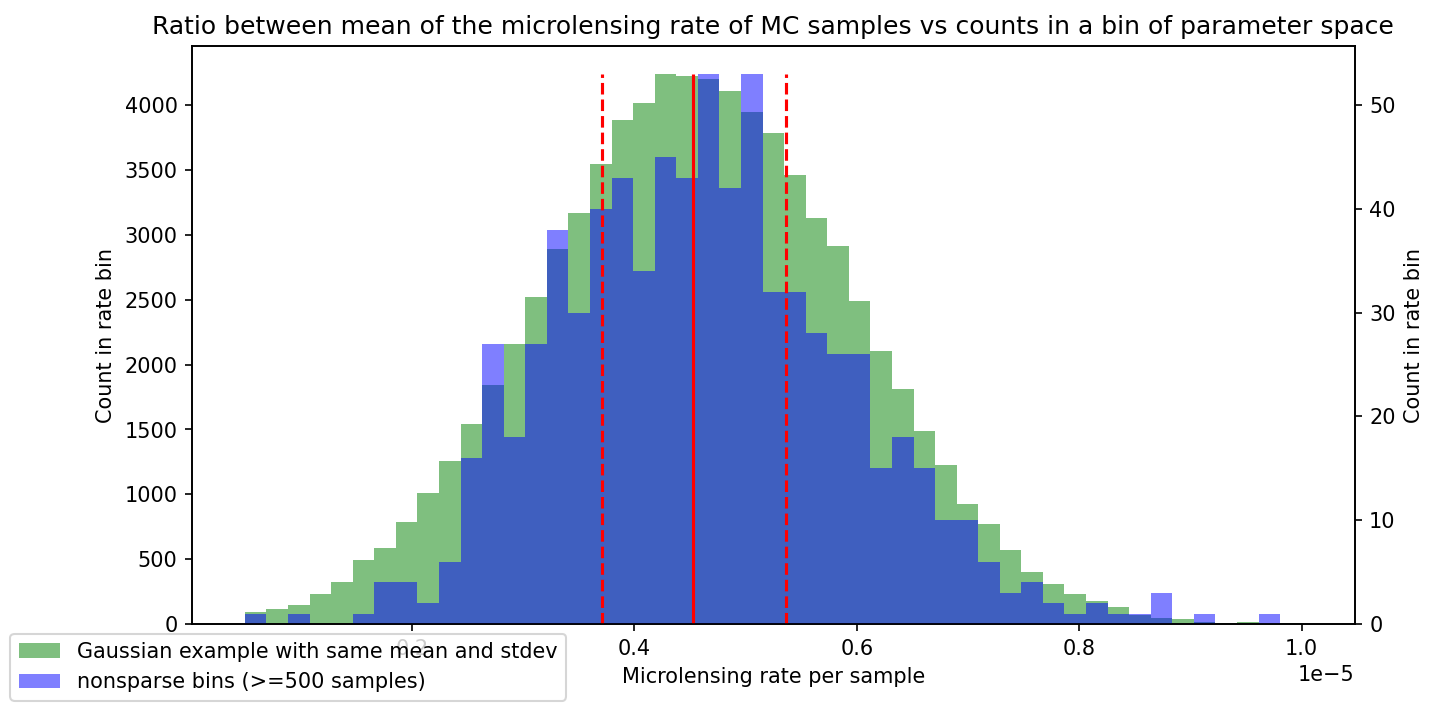

In [70]:
gauss_sample = np.random.normal(np.mean(ratio_array_not_sparse), np.std(ratio_array_not_sparse), size=100*len(ratio_array_not_sparse))
bins = np.linspace((1/2)*10**-6,10**-5,50)

fig, ax1 = plt.subplots()
ax1.hist(gauss_sample,bins=bins,label=fr'Gaussian example with same mean and stdev', alpha=.5,color='green')
plt.title('Ratio between mean of the microlensing rate of MC samples vs counts in a bin of parameter space')
ax1.set_xlabel('Microlensing rate per sample')
ax1.set_ylabel('Count in rate bin')
#ax1.set_xscale('log')
#ax1.set_ylim(0,4700)

ax2 = ax1.twinx()
vals, bins, hist = ax2.hist(ratio_array_not_sparse,bins=bins,label=fr'nonsparse bins (>={nsparse} samples)',alpha=.5, color='blue')

ax2.set_xlabel('Microlensing rate per sample')
ax2.set_ylabel('Count in rate bin')
#ax2.set_xscale('log')
#ax2.set_xlim(10**-6, (1/3)*10**-4)

mean_ratio = np.mean(ratio_array_not_sparse)
stdev = np.std(ratio_array_not_sparse)
ax2.vlines(np.percentile(ratio_array_not_sparse,(26,50,74)), 0, np.max(vals),linestyles=['dashed','solid','dashed'],color='red' )

fig.legend(loc='lower left')#['Gaussian example with same mean and stdev',fr'nonsparse bins (>={nsparse} samples)'])
#
plt.show()

In [71]:
mean_ratio

4.549981862915566e-06

# approximation of total number of microlensing events within FOV for 10 years of Rubin

In [78]:
sum(binned_rates_integral.values())*8*300*10*(120)*9.6/41250 

5971.047594466079